In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Embedding, Dense, Input, GlobalMaxPooling1D, BatchNormalization, Bidirectional, Dropout, SpatialDropout1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from pprint import pprint
from numba import cuda 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [3]:
df = pd.read_csv('cleaned_reviews_final.csv')

In [4]:
df.head()

,Unnamed: 0,review,ratings,processed_reviews
0,0,The Shawshank Redemption is written and direct...,5.0,shawshank redempt written direct frank darabon...
1,1,Why do I want to write the 234th comment on Th...,10.0,want write th comment shawshank redempt sure a...
2,2,"In its Oscar year, Shawshank Redemption (writt...",10.0,oscar year shawshank redempt written direct fr...
3,3,I'm trying to save you money; this is the last...,10.0,tri save money last film titl consid borrow re...
4,4,I have never seen such an amazing film since I...,10.0,never seen amaz film sinc saw shawshank redemp...


In [5]:
df.drop(columns=['Unnamed: 0', 'review'], inplace=True)

In [6]:
df.dtypes

ratings              float64
processed_reviews     object
dtype: object

In [7]:
df.ratings.value_counts()

1.0     26573
10.0    17119
5.0     10025
9.0      5844
8.0      3763
2.0      3606
3.0      2902
7.0      2664
6.0      2355
4.0      2081
Name: ratings, dtype: int64

In [8]:
df.reset_index(drop=True, inplace=True)
from sklearn.utils import shuffle
df = shuffle(df)

In [9]:
df.head()

,ratings,processed_reviews
55618,4.0,know mani like like kind stuff saw first ep fu...
67530,1.0,serious gordon drag know death yet wake yell g...
21398,9.0,tenaci better great song absurd humor deliv st...
32175,3.0,tri like show suppos five women live coto de c...
64112,5.0,watch show eddi cibrian join like around see e...


In [10]:
filt1 = (df['ratings'] == 2.0) | (df['ratings'] == 1.0)
df.loc[filt1, 'ratings'] = 0.0

filt2 = (df['ratings'] == 3.0) | (df['ratings'] == 4.0)
df.loc[filt2, 'ratings'] = 1.0

filt3 = (df['ratings'] == 5.0) | (df['ratings'] == 6.0)
df.loc[filt3, 'ratings'] = 2.0

filt4 = (df['ratings'] == 7.0) | (df['ratings'] == 8.0)
df.loc[filt4, 'ratings'] = 3.0

filt5 = (df['ratings'] == 9.0) | (df['ratings'] == 10.0)
df.loc[filt5, 'ratings'] = 4.0

In [11]:
df.ratings.value_counts()

0.0    30179
4.0    22963
2.0    12380
3.0     6427
1.0     4983
Name: ratings, dtype: int64

In [12]:
df.ratings = df.ratings.astype(int)

In [13]:
df.ratings.value_counts()

0    30179
4    22963
2    12380
3     6427
1     4983
Name: ratings, dtype: int64

In [14]:
df.isnull().sum()

ratings              0
processed_reviews    6
dtype: int64

In [15]:
df.dropna(subset = ['processed_reviews'], inplace=True)

In [16]:
df.isnull().sum()

ratings              0
processed_reviews    0
dtype: int64

In [17]:
X = df['processed_reviews'].astype(str)
y = df['ratings']

In [18]:
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

In [19]:
tokenizer.fit_on_texts(X)
seq = tokenizer.texts_to_sequences(X)

In [20]:
word_to_int = tokenizer.word_index
V = len(word_to_int)
print('Unique tokens - ',V)

Unique tokens -  53951


In [21]:
data = pad_sequences(seq)

print('Shape - ',data.shape)

T = data.shape[1]

Shape -  (76926, 921)


In [23]:
data = np.asarray(data)
y = np.asarray(y)

In [24]:
#Embedding dimensionality
D = 40
# Hidden states
M = 30

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = SpatialDropout1D(0.7)(x)
# x = LSTM(M, dropout=0.4, recurrent_dropout=0.4)(x)
x = LSTM(M)(x)
# x = Bidirectional(LSTM(M))(x)
x = BatchNormalization()(x)
# x = GlobalMaxPooling1D()(x)
x = Dense(60, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)

model = Model(i, x)

In [27]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c = model.fit(data, y, epochs=50)

Epoch 1/50
2404/2404 [==============================] - 175s 73ms/step - loss: 1.2065 - accuracy: 0.5624
Epoch 2/50
2404/2404 [==============================] - 173s 72ms/step - loss: 1.0687 - accuracy: 0.6241
Epoch 3/50
2404/2404 [==============================] - 169s 70ms/step - loss: 1.0188 - accuracy: 0.6373
Epoch 4/50
2404/2404 [==============================] - 177s 74ms/step - loss: 0.9807 - accuracy: 0.6488
Epoch 5/50
2404/2404 [==============================] - 179s 75ms/step - loss: 0.9453 - accuracy: 0.6602
Epoch 6/50
2404/2404 [==============================] - 180s 75ms/step - loss: 0.9189 - accuracy: 0.6716
Epoch 7/50
2404/2404 [==============================] - 185s 77ms/step - loss: 0.8935 - accuracy: 0.6796
Epoch 8/50
2404/2404 [==============================] - 183s 76ms/step - loss: 0.8734 - accuracy: 0.6856
Epoch 9/50
2404/2404 [==============================] - 184s 76ms/step - loss: 0.8523 - accuracy: 0.6936
Epoch 10/50
2404/2404 [==============================] 

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 921)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 921, 40)           2158080   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 921, 40)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 30)                8520      
_________________________________________________________________
batch_normalization (BatchNo (None, 30)                120       
_________________________________________________________________
dense (Dense)                (None, 60)                1860      
_________________________________________________________________
dropout (Dropout)            (None, 60)                0     

In [37]:
def plot(c, param):
    plt.plot(c.history[param], label=param)
    plt.legend()

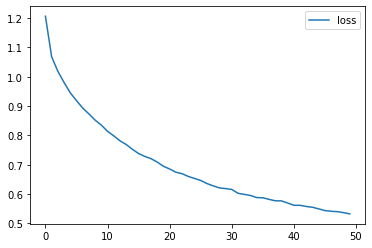

In [38]:
plot(c, 'loss')

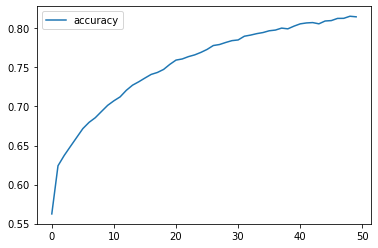

In [39]:
plot(c, 'accuracy')

In [32]:
model.save('model_LSTMFullData.h5')

In [33]:
import pickle
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [34]:
def release_gpu_memory():
    device = cuda.get_current_device()
    device.reset()

In [35]:
release_gpu_memory()